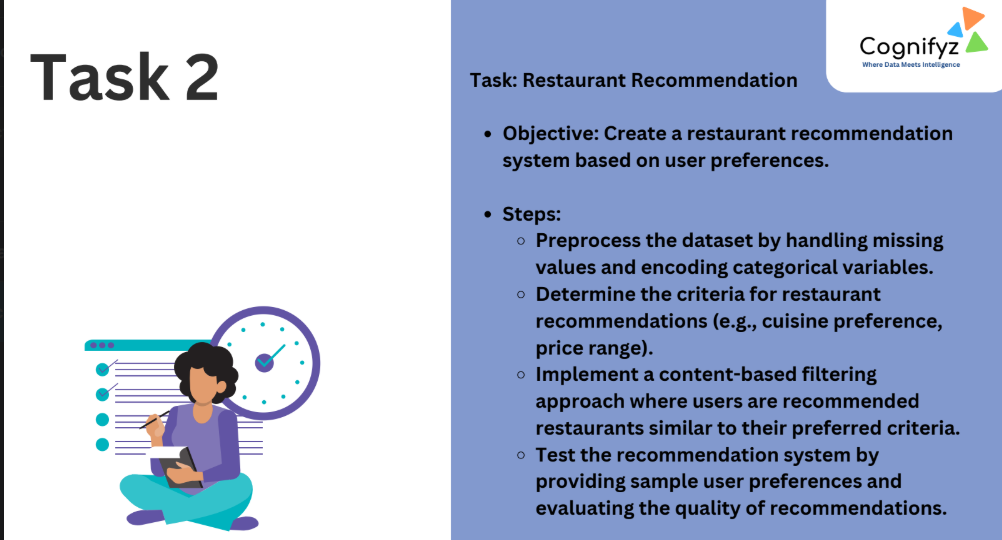

# 1. **Importing Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack, csr_matrix

# 2. **Importing Dataset**

In [ ]:
data = pd.read_csv("/Dataset .csv")  #Dataset provided in the drive link
data.columns = data.columns.str.strip().str.lower().str.replace(" ", "_")
data = data.drop_duplicates().reset_index(drop=True)


In [ ]:
# Fill missing values
if 'cuisines' in data.columns:
    data['cuisines'] = data['cuisines'].fillna("")
if 'aggregate_rating' in data.columns:
    data['aggregate_rating'] = pd.to_numeric(data['aggregate_rating'], errors='coerce').fillna(data['aggregate_rating'].mean())
if 'price_range' in data.columns:
    data['price_range'] = data['price_range'].fillna(2)

#creating price categories
price_labels = {1: "Budget ($)", 2: "Moderate ($$)", 3: "Expensive ($$$)", 4: "Luxury ($$$$)"}
data['price_text'] = data['price_range'].apply(lambda v: price_labels.get(int(v), "Unknown") if str(v).isdigit() else str(v))

#classifying Cuisines Based on Continents
cuisine_groups = {
    "Asian": ["Chinese", "Japanese", "Thai", "Korean", "Vietnamese", "Malaysian", "Indonesian", "Singaporean", "Asian"],
    "Indian": ["North Indian", "South Indian", "Biryani", "Mughlai", "Kerala", "Goan", "Rajasthani", "Bengali", "Gujarati", "Andhra"],
    "Middle Eastern": ["Turkish", "Lebanese", "Persian", "Iranian", "Arabian", "Afghan", "Middle Eastern"],
    "European": ["French", "Italian", "Spanish", "Portuguese", "Greek", "German", "British", "Irish", "European"],
    "American": ["American", "BBQ", "Tex-Mex", "Steak", "Burger", "Fast Food", "South American", "Mexican"],
    "African": ["Moroccan", "Ethiopian", "Egyptian", "African"],
    "Other/Global": ["Cafe", "Bakery", "Desserts", "Ice Cream", "Juices", "Beverages", "Pizza", "Sandwich", "Seafood"]
}
def find_group(cuisine_str):
    cuisines_list = [c.strip().lower() for c in cuisine_str.split(",") if c.strip()]
    matched_group = None

    for group, items in cuisine_groups.items():
        items_lower = [x.lower() for x in items]
        if all(c in items_lower for c in cuisines_list):
            matched_group = group
            break

    return matched_group if matched_group else "Mixed/Other"

# Create the 'cuisine_group' column
data['cuisine_group'] = data['cuisines'].apply(find_group)


def price_to_num(value):
    if pd.isna(value):
        return np.nan
    val_str = str(value)
    if val_str.isdigit():
        return int(val_str)
    return np.nan
data['price_val'] = data['price_range'].apply(price_to_num).fillna(data['price_range'].median())


info_columns = ['restaurant_name', 'cuisines', 'city', 'locality', 'address']
data['all_text'] = data[info_columns].fillna("").agg(" ".join, axis=1)


vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=5000)
text_vectors = vectorizer.fit_transform(data['all_text'])
scaler = MinMaxScaler()
num_features = scaler.fit_transform(data[['aggregate_rating', 'price_val']])
num_features = csr_matrix(num_features)
feature_matrix = hstack([text_vectors * 0.7, num_features[:, [0]] * 0.2, num_features[:, [1]] * 0.1])

# **Function to Recommend Restaurant**

In [ ]:
def suggest_places(user_choices, top_n=5):
    cuisine_str = " ".join(user_choices.get('cuisines', [])) or "restaurant"
    user_text_vec = vectorizer.transform([cuisine_str]) * 0.7
    min_rate = float(user_choices.get('min_rating', 0.0))
    budget_pick = user_choices.get('budget', None)
    budget_val = data[data['price_text'] == budget_pick]['price_val'].median() if budget_pick else data['price_val'].median()
    num_data_vec = csr_matrix(scaler.transform([[min_rate, budget_val]]))
    final_user_vec = hstack([user_text_vec, num_data_vec[:, [0]] * 0.2, num_data_vec[:, [1]] * 0.1])
    scores = cosine_similarity(final_user_vec, feature_matrix)[0]
    sorted_idx = np.argsort(scores)[::-1][:top_n]
    recommendations = data.iloc[sorted_idx].copy()
    recommendations['similarity'] = scores[sorted_idx]
    return recommendations

In [ ]:
from tabulate import tabulate

if __name__ == "__main__":
    groups = sorted(data['cuisine_group'].unique())
    print("\nCuisine Groups:")
    for i, g in enumerate(groups, 1):
        print(f"{i}. {g}")
    group_choice = input("\nPick a group number: ")
    selected_group = groups[int(group_choice) - 1] if group_choice.strip().isdigit() else groups[0]

    # Show only cuisines that belong to the selected group
    available_cuisines = sorted(
        set(
            c.strip()
            for row in data[data['cuisine_group'] == selected_group]['cuisines']
            for c in row.split(",")
            if c.strip()
        )
    )

    print(f"\nCuisines in {selected_group}:")
    for i, c in enumerate(available_cuisines, 1):
        print(f"{i}. {c}")
    cuisine_pick = input("\nEnter cuisine numbers (comma separated): ")
    selected_cuisines = [
        available_cuisines[int(x.strip()) - 1]
        for x in cuisine_pick.split(",")
        if x.strip().isdigit()
    ]

    price_opts = sorted(data['price_text'].unique())
    print("\nPrice ranges:")
    for i, p in enumerate(price_opts, 1):
        print(f"{i}. {p}")
    price_pick = input("\nPick price range number: ")
    chosen_price = price_opts[int(price_pick) - 1] if price_pick.strip().isdigit() else None

    min_rate_input = float(input("\nMinimum rating (e.g. 4.0): ") or 0.0)

    user_settings = {
        "cuisines": selected_cuisines,
        "min_rating": min_rate_input,
        "budget": chosen_price
    }

    # to Generate recommendations
    recommendations = suggest_places(user_settings, top_n=10).reset_index(drop=True)
    preferences_df = pd.DataFrame({
        "Chosen Group": [selected_group] * len(recommendations),
        "Selected Cuisines": [", ".join(selected_cuisines) if selected_cuisines else "Any"] * len(recommendations),
        "Budget": [chosen_price or "Any"] * len(recommendations),
        "Minimum Rating": [min_rate_input] * len(recommendations)
    })

    final_display = pd.concat(
        [preferences_df, recommendations[['restaurant_name', 'cuisines', 'aggregate_rating', 'price_text', 'similarity']]],
        axis=1
    )
    final_display = final_display.rename(columns={
        "restaurant_name": "Restaurant",
        "cuisines": "Cuisines",
        "aggregate_rating": "Rating",
        "price_text": "Price",
        "similarity": "Similarity Score"
    })
    final_display["Similarity Score"] = final_display["Similarity Score"].round(3)
    final_display["Cuisines"] = final_display["Cuisines"].apply(
        lambda x: (x[:50] + "...") if len(x) > 50 else x
    )
    final_display = final_display.sort_values(by="Similarity Score", ascending=False)
    print("\n===== Your Preferences and Suggested Restaurants =====")
    print(tabulate(final_display, headers="keys", tablefmt="grid", showindex=False))



Cuisine Groups:
1. African
2. American
3. Asian
4. European
5. Indian
6. Middle Eastern
7. Mixed/Other
8. Other/Global

Pick a group number: 5

Cuisines in Indian:
1. Andhra
2. Bengali
3. Biryani
4. Goan
5. Gujarati
6. Kerala
7. Mughlai
8. North Indian
9. Rajasthani
10. South Indian

Enter cuisine numbers (comma separated): 8

Price ranges:
1. Budget ($)
2. Expensive ($$$)
3. Luxury ($$$$)
4. Moderate ($$)

Pick price range number: 1

Minimum rating (e.g. 4.0): 3

===== Your Preferences and Suggested Restaurants =====
+----------------+---------------------+------------+------------------+----------------------------+--------------------------------------------+----------+-----------------+--------------------+
| Chosen Group   | Selected Cuisines   | Budget     |   Minimum Rating | Restaurant                 | Cuisines                                   |   Rating | Price           |   Similarity Score |
+================+=====================+============+==================+=========

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
